<a href="https://colab.research.google.com/gist/tykimos/e792fcae92de2326e273d669d652366b/keras_lstm_lotto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

main_url = "https://www.dhlottery.co.kr/gameResult.do?method=byWin"
basic_url = "https://www.dhlottery.co.kr/gameResult.do?method=byWin&drwNo="

def GetLast():
    resp = requests.get(main_url)
    soup = BeautifulSoup(resp.text, "lxml")
    result = str(soup.find("meta", {"id" : "desc", "name" : "description"})['content']) # meta
    s_idx = result.find(" ")
    e_idx = result.find("회")
    return int(result[s_idx + 1 : e_idx])

def Crawler(s_count, e_count, fp):
    for i in range(s_count , e_count + 1):
        crawler_url = basic_url + str(i)
        resp = requests.get(crawler_url)
        soup = BeautifulSoup(resp.text, "html.parser")

        text = soup.text

        s_idx = text.find(" 당첨결과")
        s_idx = text.find("당첨번호", s_idx) + 4
        e_idx = text.find("보너스", s_idx)
        numbers = text[s_idx:e_idx].strip().split()

        s_idx = e_idx + 3
        e_idx = s_idx + 3
        bonus = text[s_idx:e_idx].strip()

        s_idx = text.find("1등", e_idx) + 2
        e_idx = text.find("원", s_idx) + 1
        e_idx = text.find("원", e_idx)
        money1 = text[s_idx:e_idx].strip().replace(',','').split()[2]

        s_idx = text.find("2등", e_idx) + 2
        e_idx = text.find("원", s_idx) + 1
        e_idx = text.find("원", e_idx)
        money2 = text[s_idx:e_idx].strip().replace(',','').split()[2]

        s_idx = text.find("3등", e_idx) + 2
        e_idx = text.find("원", s_idx) + 1
        e_idx = text.find("원", e_idx)
        money3 = text[s_idx:e_idx].strip().replace(',','').split()[2]

        s_idx = text.find("4등", e_idx) + 2
        e_idx = text.find("원", s_idx) + 1
        e_idx = text.find("원", e_idx)
        money4 = text[s_idx:e_idx].strip().replace(',','').split()[2]

        s_idx = text.find("5등", e_idx) + 2
        e_idx = text.find("원", s_idx) + 1
        e_idx = text.find("원", e_idx)
        money5 = text[s_idx:e_idx].strip().replace(',','').split()[2]

        line = str(i) + ',' + numbers[0] + ',' + numbers[1] + ',' + numbers[2] + ',' + numbers[3] + ',' + numbers[4] + ',' + numbers[5] + ',' + bonus + ',' + money1 + ',' + money2 + ',' + money3 + ',' + money4 + ',' + money5
        print(line)
        line += '\n'
        fp.write(line)

last = GetLast()

fp = open('lotto.csv', 'w', encoding='utf-8-sig')
Crawler(1, last, fp)
fp.close()

ConnectionError: ('Connection aborted.', ConnectionAbortedError(10053, '현재 연결은 사용자의 호스트 시스템의 소프트웨어의 의해 중단되었습니다', None, 10053, None))

In [20]:
import pandas as pd

dataset = pd.read_csv("./lotto.csv", engine='python')
dataset.head(5)

,1,"1,10,23,29,33,37,40,16,0,143934100,5140500,113400,10000"
0,2,"2,9,13,21,25,32,42,2,2002006800,94866800,18420..."
1,3,"3,11,16,19,21,27,31,30,2000000000,0,1174100,54..."
2,4,"4,14,27,30,31,40,42,2,0,211191200,7282400,1521..."
3,5,"5,16,24,29,40,41,42,3,0,0,6033800,166500,10000"
4,6,"6,14,15,26,27,40,42,34,6574451700,196297600,42..."


In [8]:
def numbers2ohbin(numbers):

    ohbin = np.zeros(45)
    for i in range(6):
        ohbin[int(numbers[i])-1] = 1
    
    return ohbin

In [11]:
#dataset = dataset[:-1]

total_count = len(dataset)

print('total_count {0}'.format(total_count))

numbers = dataset[:, 1:7]
samples = list(map(numbers2ohbin, numbers))

x_train = samples[0:total_count-1]
y_train = samples[1:total_count]


'''

x_val = x_train
y_val = y_train

x_test = x_train
x_test = y_train


x_train = samples[0:700]
y_train = samples[1:701]
x_val = samples[700:800]
y_val = samples[701:801]
x_test = samples[800:total_count-1]
y_test = samples[801:total_count]
'''

NameError: name 'dataset' is not defined

In [26]:
from __future__ import absolute_import, division, print_function, unicode_literals
%pip install tensorflow-gpu==2.0.0-rc1

     |████████████████████████████████| 380.5MB 43kB/s 
     |████████████████████████████████| 501kB 40.8MB/s 
     |████████████████████████████████| 4.3MB 33.4MB/s 


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

model = keras.Sequential([
    keras.layers.LSTM(128, batch_input_shape=(1, 1, 45), return_sequences=False, stateful=True),
    keras.layers.Dense(45, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [5]:
print('Train...')

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(100):

    mean_train_loss = []
    mean_train_acc = []
    
    model.reset_states()

    for i in range(len(x_train)):
        
        xs = x_train[i].reshape(1, 1, 45)
        ys = y_train[i].reshape(1, 45)
        
        loss, acc = model.train_on_batch(xs, ys)

        mean_train_loss.append(loss)
        mean_train_acc.append(acc)

    train_loss.append(np.mean(mean_train_loss))
    train_acc.append(np.mean(mean_train_acc))

    '''
    mean_val_loss = []
    mean_val_acc = []

    for i in range(len(x_val)):

        xs = x_val[i].reshape(1, 1, 45)
        ys = y_val[i].reshape(1, 45)
        
        loss, acc = model.test_on_batch(xs, ys)
        
        mean_val_loss.append(loss)
        mean_val_acc.append(acc)

    val_loss.append(np.mean(mean_val_loss))
    val_acc.append(np.mean(mean_val_acc))

    print('epoch {0:2d} train acc {1:0.3f} loss {2:0.3f} val acc {3:0.3f} loss {4:0.3f}'.format(epoch, np.mean(mean_train_acc), np.mean(mean_train_loss), np.mean(mean_val_acc), np.mean(mean_val_loss)))
    '''

    print('epoch {0:2d} train acc {1:0.3f} loss {2:0.3f}'.format(epoch, np.mean(mean_train_acc), np.mean(mean_train_loss)))

Train...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
epoch  0 train acc 0.863 loss 0.407
epoch  1 train acc 0.867 loss 0.396
epoch  2 train acc 0.867 loss 0.394
epoch  3 train acc 0.867 loss 0.392
epoch  4 train acc 0.867 loss 0.388
epoch  5 train acc 0.867 loss 0.383
epoch  6 train acc 0.867 loss 0.378
epoch  7 train acc 0.867 loss 0.372
epoch  8 train acc 0.867 loss 0.366
epoch  9 train acc 0.867 loss 0.359
epoch 10 train acc 0.868 loss 0.352
epoch 11 train acc 0.868 loss 0.345
epoch 12 train acc 0.869 loss 0.337
epoch 13 train acc 0.871 loss 0.328
epoch 14 train acc 0.872 loss 0.319
epoch 15 train acc 0.875 loss 0.310
epoch 16 train acc 0.878 loss 0.300
epoch 17 train acc 0.882 loss 0.289
epoch 18 train acc 0.886 loss 0.278
epoch 19 train acc 0.891 loss 0.267
epoch 20 train acc 0.895 loss 0.257
epoch 21 train acc 0.900 loss 0.246
epoch 22 train acc 0.906 loss 0.235
epoch 23 train acc 0.910 loss 0.225
epoch 24 train acc 0.914 loss 0.2

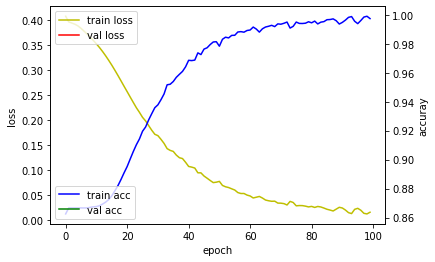

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(train_loss, 'y', label='train loss')
loss_ax.plot(val_loss, 'r', label='val loss')

acc_ax.plot(train_acc, 'b', label='train acc')
acc_ax.plot(val_acc, 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
model.save('model.h5')

In [ ]:
import numpy as np
from tensorflow.keras import models

model = models.load_model('model.h5')

In [9]:

mean_prize = [ np.mean(dataset[87:, 8]),
           np.mean(dataset[87:, 9]),
           np.mean(dataset[87:, 10]),
           np.mean(dataset[87:, 11]),
           np.mean(dataset[87:, 12])]

print(mean_prize)           

[2434854568.0359354, 57192272.95167286, 1451891.8711276331, 53061.93060718711, 5000.0]


In [ ]:
def calc_reward(true_numbers, true_bonus, pred_numbers):

    count = 0

    for ps in pred_numbers:
        if ps in true_numbers:
            count += 1

    if count == 6:
        return mean_prize[0], count
    elif count == 5 and true_bonus in pred_numbers:
        return mean_prize[1], count
    elif count == 5:
        return mean_prize[2], count
    elif count == 4:
        return mean_prize[3], count
    elif count == 3:
        return mean_prize[4], count

    return 0, count

In [ ]:
def gen_numbers_from_probability(nums_prob):

    ball_box = []

    for n in range(45):
        ball_count = int(nums_prob[n] * 100 + 1)
        ball = np.full((ball_count), n+1) #1부터 시작
        ball_box += list(ball)

    selected_balls = []

    while True:
        
        if len(selected_balls) == 6:
            break
        
        ball_index = np.random.randint(len(ball_box), size=1)[0]
        ball = ball_box[ball_index]

        #print('{0} {1} {2}'.format(len(ball_box), ball_index, ball))

        if ball not in selected_balls:
            selected_balls.append(ball)

    return selected_balls

In [12]:
model.reset_states()

gi = 1

rewards = []

for i in range(len(x_train)):
    xs = x_train[i].reshape(1, 1, 45)
    ys_pred = model.predict_on_batch(xs)
    
    sum_rewards = 0

    print('No.{0:3d} True Numbers {1}'.format(gi+1, dataset[gi,1:7]))
    
    for n in range(10):
        numbers = gen_numbers_from_probability(ys_pred[0])
        reward, count = calc_reward(dataset[gi,1:7], dataset[gi,7], numbers)
        
        print('{0:2d} {1:15,d} {2:4d} {3}'.format(n, int(reward), count, numbers))

        sum_rewards += reward
    
    print('Total Reward: {0:15,d}'.format(int(sum_rewards)))

    rewards.append(sum_rewards)
    gi += 1
'''
for i in range(len(x_val)):
    xs = x_val[i].reshape(1, 1, 45)
    ys_pred = model.predict_on_batch(xs)

    sum_rewards = 0
    for n in range(10):
        numbers = gen_numbers_from_probability(ys_pred[0])
        sum_rewards += calc_reward(dataset[gi,1:7], dataset[gi,7], numbers)

    print('{0:4d} {1} {2} {3:.1f}'.format(gi, dataset[gi,1:7], numbers, sum_rewards))
    rewards.append(sum_rewards)
    gi += 1

for i in range(len(x_test)):
    xs = x_test[i].reshape(1, 1, 45)
    ys_pred = model.predict_on_batch(xs)

    sum_rewards = 0

    for n in range(10):
        numbers = gen_numbers_from_probability(ys_pred[0])
        sum_rewards += calc_reward(dataset[gi,1:7], dataset[gi,7], numbers)

    print('{0:4d} {1} {2} {3:.1f}'.format(gi, dataset[gi,1:7], numbers, sum_rewards))
    rewards.append(sum_rewards)
    gi += 1
'''    

No.  2 True Numbers [ 9. 13. 21. 25. 32. 42.]
 0   2,434,854,568    6 [21, 42, 25, 9, 32, 13]
 1   2,434,854,568    6 [9, 13, 21, 42, 25, 32]
 2          53,061    4 [2, 21, 13, 3, 25, 9]
 3       1,451,891    5 [42, 32, 9, 25, 3, 13]
 4          53,061    4 [11, 13, 9, 21, 42, 3]
 5       1,451,891    5 [9, 25, 32, 13, 42, 11]
 6          53,061    4 [1, 25, 32, 19, 13, 21]
 7          53,061    4 [25, 13, 8, 42, 31, 9]
 8      57,192,272    5 [32, 21, 13, 42, 9, 2]
 9   2,434,854,568    6 [21, 42, 32, 13, 9, 25]
Total Reward:   7,364,872,008
No.  3 True Numbers [11. 16. 19. 21. 27. 31.]
 0   2,434,854,568    6 [16, 21, 31, 19, 11, 27]
 1       1,451,891    5 [21, 19, 31, 16, 2, 11]
 2       1,451,891    5 [11, 21, 19, 31, 16, 36]
 3   2,434,854,568    6 [16, 21, 27, 19, 31, 11]
 4       1,451,891    5 [19, 31, 10, 27, 16, 11]
 5       1,451,891    5 [16, 11, 39, 21, 27, 31]
 6          53,061    4 [2, 11, 19, 27, 14, 21]
 7   2,434,854,568    6 [27, 31, 21, 19, 11, 16]
 8       1,451

"\nfor i in range(len(x_val)):\n    xs = x_val[i].reshape(1, 1, 45)\n    ys_pred = model.predict_on_batch(xs)\n\n    sum_rewards = 0\n    for n in range(10):\n        numbers = gen_numbers_from_probability(ys_pred[0])\n        sum_rewards += calc_reward(dataset[gi,1:7], dataset[gi,7], numbers)\n\n    print('{0:4d} {1} {2} {3:.1f}'.format(gi, dataset[gi,1:7], numbers, sum_rewards))\n    rewards.append(sum_rewards)\n    gi += 1\n\nfor i in range(len(x_test)):\n    xs = x_test[i].reshape(1, 1, 45)\n    ys_pred = model.predict_on_batch(xs)\n\n    sum_rewards = 0\n\n    for n in range(10):\n        numbers = gen_numbers_from_probability(ys_pred[0])\n        sum_rewards += calc_reward(dataset[gi,1:7], dataset[gi,7], numbers)\n\n    print('{0:4d} {1} {2} {3:.1f}'.format(gi, dataset[gi,1:7], numbers, sum_rewards))\n    rewards.append(sum_rewards)\n    gi += 1\n"

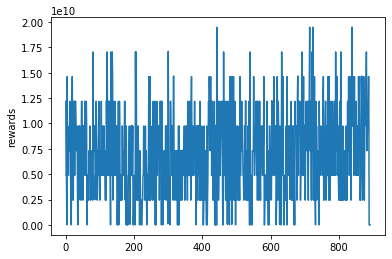

In [116]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(rewards)
plt.ylabel('rewards')
plt.show()

In [13]:
print('receive numbers')

xs = samples[-1].reshape(1, 1, 45)

ys_pred = model.predict_on_batch(xs)

list_numbers = []

for n in range(10):
    numbers = gen_numbers_from_probability(ys_pred[0])
    print('{0} : {1}'.format(n, numbers))
    list_numbers.append(numbers)

receive numbers
0 : [26, 12, 23, 44, 31, 6]
1 : [26, 43, 12, 31, 3, 41]
2 : [40, 44, 20, 12, 26, 41]
3 : [26, 24, 40, 31, 7, 12]
4 : [12, 26, 23, 43, 31, 41]
5 : [31, 27, 43, 26, 5, 28]
6 : [41, 40, 26, 23, 34, 43]
7 : [23, 41, 12, 40, 43, 39]
8 : [26, 40, 31, 12, 23, 41]
9 : [31, 26, 41, 43, 40, 44]


In [54]:
print('rewards check')
total_rewards = 0

for n in range(len(list_numbers)):
    reward, count = calc_reward([19,32,37,40,41,43], [45], list_numbers[n])
    print('{0} {1:15,d}'.format(count, int(reward)))
    total_rewards += reward

print('Total {0:15,d}'.format(int(total_rewards)))

[[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1.
   0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]]
